In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
import scipy.optimize as optimize
import itertools

# Harmonic expansion

A velocity map $K(a, \psi)$ can be approach as elliptical rings with a velocity profile which can be described by a finite harmonic expansion as follows:

$K(a, \psi) = A_0(a) + \sum_{n= 1}^{N}A_n(a)sin(n\psi) + B_n(a)cos(n\psi)$,

where $\psi$ is the eccentric anomaly and $a$ is the length of the semimajor axis of the elliptical ring.

To implement the harmonic expansion to data, we need:

1) To determine the parameters of the best-sampling ellipse. For this purpose, we need to fit a velocity map with a small number of harmonic terms:

$K(\psi) = A_0 +A_1sin(\psi) + B_1cos(\psi) + A_2sin(2\psi) + B_2cos(2\psi) + A_3sin(3\psi) + B_3cos(3\psi)$

caminata aleatoria para diferentes a, q y Gamma y un mismo centro, creo la elipse, recupero las velocidades de los datos en la elipse, luego ajusto la velocidad para Gamma, y encuentro los parámetros de ajuste que minizen $\chi^2$

# Process with nan data

In [2]:
def K_0(psi, A0, A1, B1, A2, B2, A3, B3):
    """
    Function to calculate the ellipse parameters for a velocity map.
    
    Parameters:
    -----------
    psi : position angle or eccentric anomaly
    
    Return:
    ----------
    v_los : Velocity map
    """ 
    psi_rad = psi*np.pi/180
    K = A0 + A1*np.sin(psi_rad) + B1*np.cos(psi_rad) + A2*np.sin(2*psi_rad) + B2*np.cos(2*psi_rad) \
         + A3*np.sin(3*psi_rad) + B3*np.cos(3*psi_rad)
             
    return K

In [3]:
def K_0_4fit(matriz, A0, A1, B1, A2, B2, A3, B3):
    """
    Function to calculate the ellipse parameters for a velocity map.
    
    Parameters:
    -----------
    psi : position angle or eccentric anomaly
    mask : mask with shape of our object (eg. elliptical ring)
    
    Return:
    ----------
    v_los : Velocity map
    """ 
    psi = matriz[0]
    mask = matriz[1]
    psi_rad = psi*np.pi/180
    K = A0 + A1*np.sin(psi_rad) + B1*np.cos(psi_rad) + A2*np.sin(2*psi_rad) + B2*np.cos(2*psi_rad) \
         + A3*np.sin(3*psi_rad) + B3*np.cos(3*psi_rad)
             
    K = K*mask  
    K = K[~np.isnan(mask)]

    return K 

In [4]:
def ellipse(h, k, a, b, phi, xx, yy):
    
    xp = (xx-h)*np.cos(phi) + (yy-k)*np.sin(phi)
    yp = -(xx-h)*np.sin(phi) + (yy-k)*np.cos(phi)
    eq = (xp/a)**2 + (yp/b)**2 
    mask = np.ones((182,182))
    mask[eq > 1.05] = 'nan'
    mask[eq < 0.95] = 'nan'

    return mask

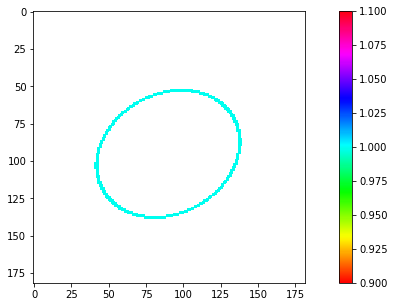

In [5]:
# creamos los vectores con las coordenadas x,y
x = np.arange(182)
y = np.arange(182)
# Array de coordenadas x,y, un elemento por cada pixel en la imagen
yy,xx = np.meshgrid(x,y)
mask = ellipse(95, 90, 40, 50, np.sin(np.deg2rad(30)), xx, yy)

plt.figure(figsize=(12,5))
plt.imshow(mask,cmap="hsv",interpolation=None)
plt.colorbar()

plt.show()

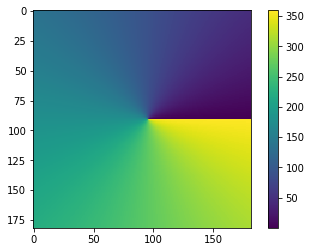

In [6]:
Psi = np.arctan((yy-95.5)/(xx-90.5))
Psi = np.rad2deg(Psi) + 90
Psi[91:,:] = Psi[91:,:]+180

plt.imshow(Psi)
plt.colorbar()

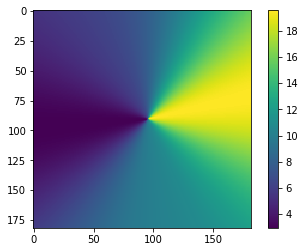

In [7]:
plt.imshow(K_0(Psi, 10, 0,7, 1, 1, 1, 1))
plt.colorbar()

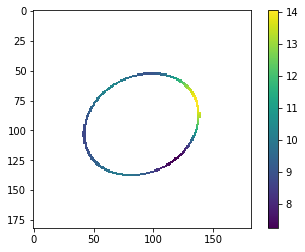

In [8]:
plt.imshow(K_0(Psi, 10, 1, 1, 1, 1, 1, 1)*mask)
plt.colorbar()

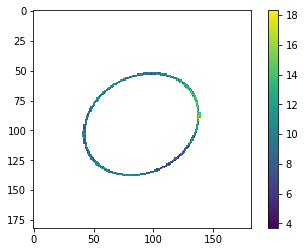

In [9]:
noise = np.random.normal(0, 1.5, size=(182, 182))
plt.imshow((K_0(Psi, 10, 1, 1, 1, 1, 1, 1)+noise)*mask,interpolation=None)
plt.colorbar()

In [10]:
ellip_noise = noise*mask
syn_data = K_0_4fit([Psi, mask], 10, 1, 1, 1, 1, 1, 1) + ellip_noise[~np.isnan(mask)]
matriz = [Psi, mask]

popt,pconv = optimize.curve_fit(K_0_4fit, matriz, syn_data, p0 = [10, 0,0,0,0,0, 0], check_finite= False) 
print(popt) 

[10.0788723   0.88672124  0.84433464  0.93556015  0.90527635  0.81137968
  1.00702862]


[ 4.22141844e+03  1.17445141e+00 -1.08539041e+02  1.26020959e+00
  1.46805817e+00  7.15651091e-01 -1.14915341e+00]


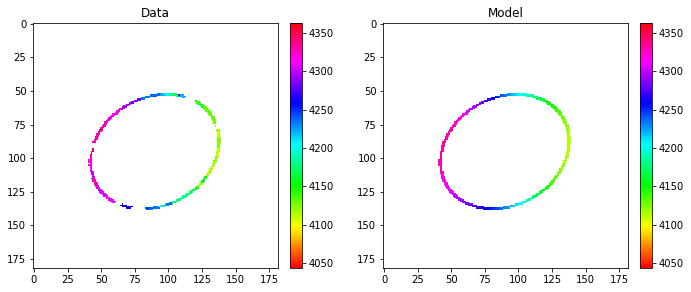

In [11]:
hdu = fits.open("Tarea 2/ugc4555_rv_voro.fits")
velmap = hdu[0].data

plt.figure(figsize = (11.5,4.5))
ax1 =  plt.subplot(1,2,1)
ax1.set_title('Data')
plt.imshow(velmap*mask,cmap="hsv", vmin = np.nanmin(velmap), vmax = np.nanmax(velmap))
plt.colorbar(fraction=0.046, pad=0.04)

data = mask*velmap
mask2 = data/data
matriz = [Psi, mask2]

popt,pconv = optimize.curve_fit(K_0_4fit, matriz, data[~np.isnan(data)], check_finite= False) 
print(popt) 
ax2 =  plt.subplot(1,2,2)
ax2.set_title('Model')
plt.imshow(K_0(Psi, *popt)*mask,cmap="hsv", vmin = np.nanmin(velmap), vmax = np.nanmax(velmap))
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


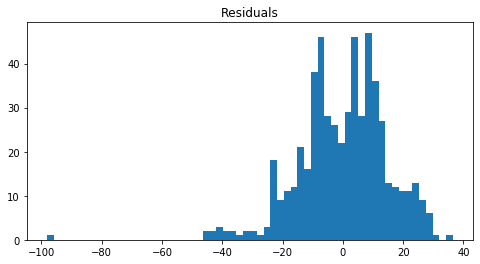

In [12]:
res = K_0(Psi, *popt)*mask-(velmap*mask)
fig, ax1 = plt.subplots(1,1, figsize=(8,4))
ax1.set_title('Residuals')
ax1.hist(res[~np.isnan(res)], bins= 60)
plt.show()

In [13]:
x = np.arange(182)
y = np.arange(182)
# Array de coordenadas x,y, un elemento por cada pixel en la imagen
yy,xx = np.meshgrid(x,y)

hdu = fits.open("Tarea 2/ugc4555_rv_voro.fits")
velmap = hdu[0].data

Psi = np.arctan((yy-95.5)/(xx-90.5))
Psi = np.rad2deg(Psi) + 90
Psi[91:,:] = Psi[91:,:]+180

q_array = np.linspace(0, 0.95, 25)
Gamma_array = np.linspace(0, 180, 25)
pars = [q_array, Gamma_array]
par_combinations = np.array(list(itertools.product(*pars)))

result = []
plt.figure(figsize = (5,5))
for pars_i in par_combinations:
    q = pars_i[0]
    Gamma = pars_i[1]
    #a_array = np.linspace(1, 50, 5)
    a_array = [20]
    for a in a_array:
        b = a*(1-q)
        mask = ellipse(95, 90, b, a, np.sin(np.deg2rad(Gamma)), xx, yy)
        #mask[mask ==0]= 'nan' 
        data = mask*velmap
        mask2 = data/data
        matriz = [Psi, mask2]
        if len(data[~np.isnan(data)]) > 10:
            popt,pconv = optimize.curve_fit(K_0_4fit, matriz, data[~np.isnan(data)], check_finite= False) 
            A0, A1, B1, A2, B2, A3, B3 = popt
            chi2 = A1**2 + A2**2 + B2**2 + A3**2 + B3**2 
            result.append([q, Gamma, chi2])
        else:
            break
plt.show()
result = np.array(result)

<Figure size 360x360 with 0 Axes>

Text(0, 0.5, '$\\Gamma$')

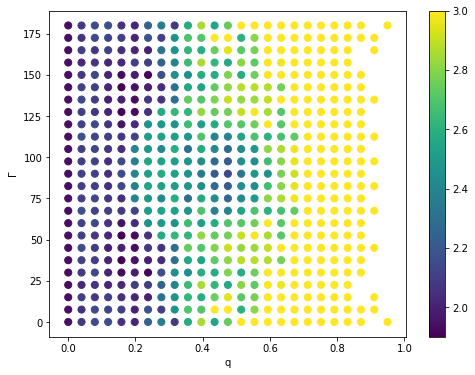

In [14]:
f, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(result[:,0], result[:,1], c= np.log10(result[:,2]), s= 50, vmax = 3)
cb = f.colorbar(sc, ax=ax)
ax.set_xlabel('q')
ax.set_ylabel(r'$\Gamma$')

In [ ]:


#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)



2) To repeat the fit using the parameters of the best-sampling ellipse found in the previous step.